In [216]:
train_data = [
    [2.3976, 1.5328, 1.9044, 1.1937, 2.4184, 1.8649, 1],
    [2.3936, 1.4804, 1.9907, 1.2732, 2.2719, 1.8110, 1],
    [2.2880, 1.4585, 1.9867, 1.2451, 2.3389, 1.8099, 1],
    [2.2904, 1.4766, 1.8876, 1.2706, 2.2966, 1.7744, 1],
    [1.1201, 0.0587, 1.3154, 5.3783, 3.1849, 2.4276, 2],
    [0.9913, 0.1524, 1.2700, 5.3808, 3.0714, 2.3331, 2],
    [1.0915, 0.1881, 1.1387, 5.3703, 3.3561, 2.3833, 2],
    [1.0535, 0.1229, 1.2743, 5.3226, 3.0952, 2.3193, 2],
    [1.4871, 2.3448, 0.9918, 2.3160, 1.6783, 5.0850, 3],
    [1.3312, 2.2553, 0.9618, 2.4702, 1.7272, 5.0645, 3],
    [1.3646, 2.2945, 1.0562, 2.4763, 1.8051, 5.1470, 3],
    [1.4392, 2.2296, 1.1278, 2.4230, 1.7259, 5.0876, 3],
    [2.9364, 1.5323, 4.6109, 1.3160, 4.2000, 6.8749, 4],
    [2.9034, 1.4640, 4.6061, 1.4598, 4.2912, 6.9142, 4],
    [3.0181, 1.4918, 4.7051, 1.3521, 4.2623, 6.7966, 4],
    [2.9374, 1.4896, 4.7219, 1.3977, 4.1863, 6.8336, 4]
]

test_data = [
    [2.9817, 1.5656, 4.8391, 1.4311, 4.1916, 6.9718],
    [1.5537, 2.2615, 1.3169, 2.5873, 1.7570, 5.0958],
    [1.2240, 0.2445, 1.3595, 5.4192, 3.2027, 2.5675],
    [2.5828, 1.5146, 2.1119, 1.2859, 2.3414, 1.8695],
    [2.4168, 1.4857, 1.8959, 1.3013, 2.4500, 1.7868],
    [1.0604, 0.2276, 1.2806, 5.4732, 3.2133, 2.4839],
    [1.5246, 2.4254, 1.1353, 2.5325, 1.7569, 5.2640],
    [3.0565, 1.6259, 4.7743, 1.3654, 4.2904, 6.9808]
             ]


In [ ]:
import numpy as np

# all_data = np.array(train_data + test_data)
train_data = np.array(train_data)
test_data = np.array(test_data)


ValueError: operands could not be broadcast together with shapes (16,7) (8,6) 

In [246]:
import numpy as np
import matplotlib.pyplot as plt

class LVQ_1:
    def __init__(self, input_size, weight_size, hyper_params):
        self.input_size = input_size
        self.hyper_params = hyper_params

        # 將參考向量的設為 0
        self.weight = np.zeros((weight_size, input_size))
        self.labels = np.zeros(weight_size)

    def weight_init(self, weight, labels, samples):
        # 將每個參考向量平均分配給每個 class
        unique_labels = np.unique(labels)
        n_label = self.weight.shape[0] // len(unique_labels)
        idx = 0
        for label in unique_labels:
            single_class_samples = samples[labels == label]
            # 選取 n_label 個對應 class 的 sample 作為初始參考向量
            weight[idx:idx+n_label] = single_class_samples[\
                np.random.choice(len(single_class_samples), n_label, replace=False)]
            self.labels[idx:idx+n_label] = label
            idx += n_label  
        return weight
    
    def cal_input_weight_distance(self, x, weight):
        # 將所有 weight point 個別減去同個 x 後取歐式距離 (L2 norm)
        x_reshaped = x.reshape(1, -1)
        distances = np.linalg.norm(weight - x_reshaped, axis=1)
        return distances

    def find_winner(self, x):
        distances = self.cal_input_weight_distance(x, self.weight)
        # 找到距離當前 x 最近的 weight point 的 index
        return np.argmin(distances)

    def update_weight(self, x, y, winner_pos):
        if y == self.labels[winner_pos]:
            # 距離最近的參考向量的 class 與當前 sample 的 class 相同，將參考向量往靠近 sample 靠近
            self.weight[winner_pos] += self.hyper_params['lr'] * (x - self.weight[winner_pos])
        else:
            # 距離最近的參考向量的 class 與當前 sample 的 class 不同，將參考向量遠離 sample
            self.weight[winner_pos] -= self.hyper_params['lr'] * (x - self.weight[winner_pos])

    def train(self, train_data, test_data):
        samples = train_data[:, :-1]
        labels = train_data[:, -1]
        test_samples = test_data[:, :-1]
        test_labels = test_data[:, -1]
        self.weight = self.weight_init(self.weight, labels, samples)
        
        err_arr = []
        for _ in range(self.hyper_params['epochs']):    
            for (x, y) in zip(samples, labels):
                winner_pos = self.find_winner(x)
                self.update_weight(x, y, winner_pos)

            err_arr.append(self.cal_err(samples, labels))
        self.plot_convergence(err_arr)
    
    def cal_err(self, samples, labels):
        total_err = 0
        # 找出每個 weight point 的 class 所對應到的 class sample 的中心點，並計算平均距離 
        for i in range(len(self.weight)):
            class_samples = samples[labels == self.labels[i]]
            if len(class_samples) == 0:
                continue
            avg_dist = self.cal_input_weight_distance(np.mean(class_samples, axis=0), self.weight[i])     
            total_err += avg_dist
        return total_err

    def predict(self, x):
        winner_pos = self.find_winner(x)
        return self.labels[winner_pos]

    def plot_convergence(self, err_arr):
        plt.figure(figsize=(6, 5))
        plt.plot(err_arr, 'b-')
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.grid(True)
        plt.show()

    
    
def visualize_features(train_data, feat_list, model, test_data=None, pred=None):
    data, labels = train_data[:, :-1], train_data[:, -1]
    fig_size = int(np.ceil(np.sqrt(len(feat_list))))
    cmap = plt.get_cmap('tab10')
    plt.figure(figsize=(9, 9))
    for idx, (f1, f2) in enumerate(feat_list):
        plt.subplot(fig_size, fig_size, idx+1)
        plt.grid()
        plt.xlabel(f'feature {f1}')
        plt.ylabel(f'feature {f2}')
        plt.scatter(data[:, f1], data[:, f2], s=40, marker='o', facecolors='none', edgecolors=[cmap(i) for i in labels.astype(int)])
        plt.scatter(model.weight[:, f1], model.weight[:, f1], s=40, marker='x', c=[cmap(i) for i in model.labels.astype(int)])
   
    if test_data is not None:
        for idx, (f1, f2) in enumerate(feat_list):
            plt.subplot(fig_size, fig_size, idx+1)
            plt.scatter(test_data[:, f1], test_data[:, f2], s=40, marker='*', facecolors='none', edgecolors=[cmap(i) for i in pred.astype(int)])
    plt.show()

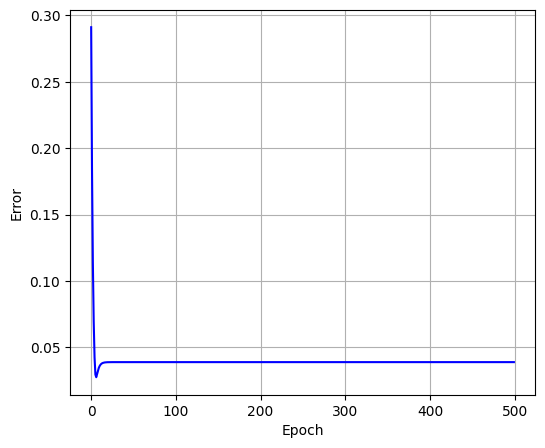

[2.9817 1.5656 4.8391 1.4311 4.1916 6.9718] 4
[1.5537 2.2615 1.3169 2.5873 1.757  5.0958] 3
[1.224  0.2445 1.3595 5.4192 3.2027 2.5675] 2
[2.5828 1.5146 2.1119 1.2859 2.3414 1.8695] 1
[2.4168 1.4857 1.8959 1.3013 2.45   1.7868] 1
[1.0604 0.2276 1.2806 5.4732 3.2133 2.4839] 2
[1.5246 2.4254 1.1353 2.5325 1.7569 5.264 ] 3
[3.0565 1.6259 4.7743 1.3654 4.2904 6.9808] 4


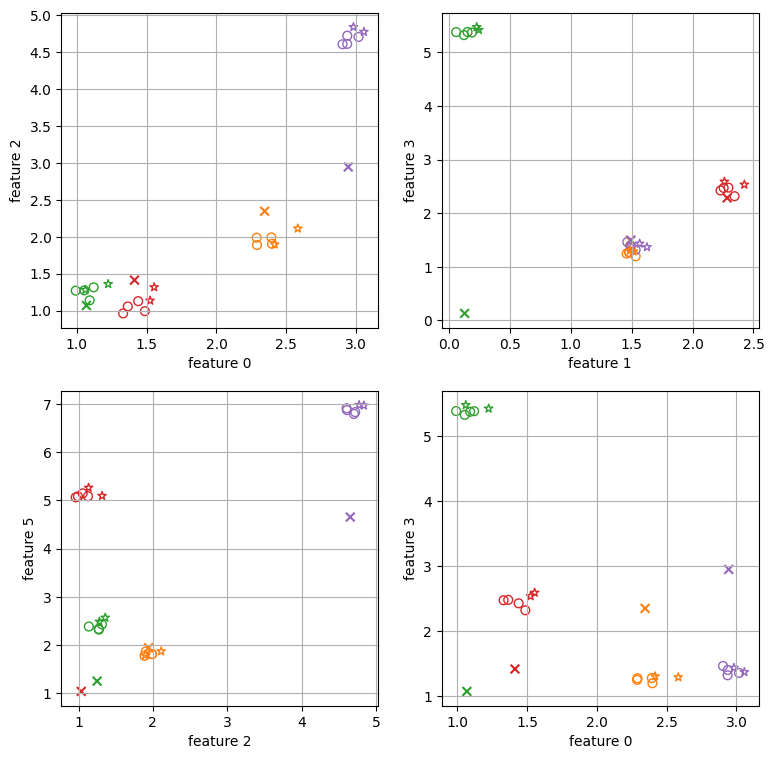

In [255]:
np.random.seed(0)
np.random.shuffle(train_data)

model = LVQ_1(input_size=6, weight_size=4, hyper_params={'epochs': 500, 'lr': 0.1})

model.train(train_data, test_data)
pred_arr = []
for x in test_data:
    pred = model.predict(x).astype(int)
    pred_arr.append(pred)
    print(x, pred)

visualize_features(train_data, [[0, 2], [1, 3], [2, 5], [0, 3]], model, test_data=test_data, pred=np.array(pred_arr))



[2.9817 1.5656 4.8391 1.4311 4.1916 6.9718] 4
[1.5537 2.2615 1.3169 2.5873 1.757  5.0958] 3
[1.224  0.2445 1.3595 5.4192 3.2027 2.5675] 2
[2.5828 1.5146 2.1119 1.2859 2.3414 1.8695] 1
[2.4168 1.4857 1.8959 1.3013 2.45   1.7868] 1
[1.0604 0.2276 1.2806 5.4732 3.2133 2.4839] 2
[1.5246 2.4254 1.1353 2.5325 1.7569 5.264 ] 3
[3.0565 1.6259 4.7743 1.3654 4.2904 6.9808] 4


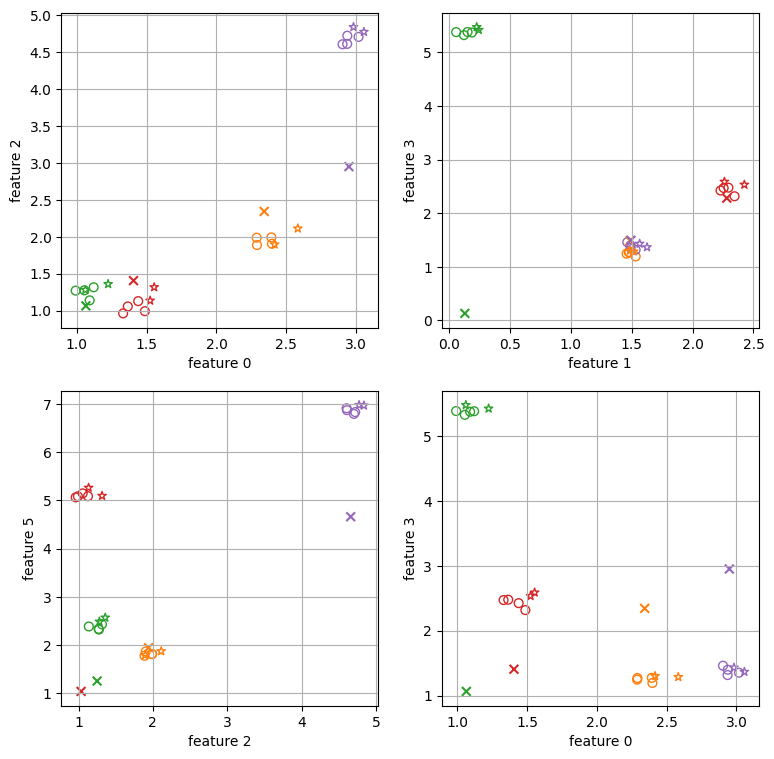

In [245]:
pred_arr = []
for x in test_data:
    pred = model.predict(x).astype(int)
    pred_arr.append(pred)
    print(x, pred)

visualize_features(train_data, [[0, 2], [1, 3], [2, 5], [0, 3]], model, test_data=test_data, pred=np.array(pred_arr))
plt.show()